### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework.

### Imran Zamin Ali

## Initial Setup

### Imports

In [1]:
#!pip install pingouin
#!pip install --upgrade pingouin

In [1]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pingouin as pg
import statsmodels
from BSE import market_session
from os import cpu_count
from multiprocessing import Pool
import cwhelpers

### Statistics

We're going to be doing a lot of experiments and statistical tests. Therefore we can make our lives a bit easier by automating them. First lets setup our statistics. Each time we a trade is made it affects the market and how much profit the proceeding traders make. This means that the samples generated **within** each market session is paired rather than independent. Our statistics function determines which test(s) to use based on the flowchart below. To read up on the which tests I used and why please refer to '100 Statistical Tests' by Gopal K Kanji (LINK), which was mentioned in Dave Cliff's leture on empirical methods, as well as the scipy (LINK) statsmodels (https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.AnovaRM.html#statsmodels.stats.anova.AnovaRM) documentation.

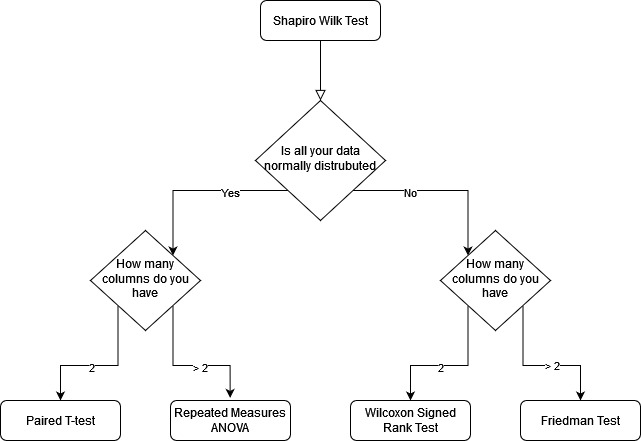

In [2]:
def anova_test(profits):
    anova = pg.rm_anova(data=profits, correction=True)
    print('Testing for sphericity with Mauchlys Test')
    sphericity = anova['p-spher'][0]
    statistic = anova['F'][0]
    pvalue = None
    if anova['sphericity'][0]:
        pvalue = anova['p-unc'][0]
        print(f'Do not reject null hyptothesis (p={sphericity}). There is enough evidence to suggest the samples have sphericity')
    else:
        pvalue = anova['p-GG-corr'][0]
        print(f'Reject null hyptothesis (p={sphericity}). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.')
    # if anova['sphericity']:
    #     print(f'Do not reject null hypothesis {p={}}')
    return statistic, pvalue

def run_stat_tests(profits):
    for col in profits.columns:
      print(f'{col}: mean={profits[col].mean()} std={profits[col].std()}')
    print('Check each column if the data is normally distrubuted with the shapiro wilk test:')
    is_normal = True
    # check if the data is normally distributed
    for col in profits.columns:
        _, pvalue = stats.shapiro(profits[col])
        if pvalue < 0.05:
            print(f'Condition: {col}. Reject null hypothesis (p={pvalue}). There is enough evidence to suggest the data is not normally distributed')
            is_normal = False
        else:
            print(f'Condition: {col}. Do not reject null hypothesis (p={pvalue}). There is enough evidence to suggest the data is normally distributed')

    columns = [profits[column] for column in profits.columns]
    is_two_dist = len(columns) == 2
    if is_two_dist:
        fig, axes = plt.subplots(1,2)
        sns.kdeplot(data=profits, fill=False, ax=axes[0])
        sns.boxplot(data=profits, ax=axes[1])
        plt.show()
        sns.violinplot(data=profits, inner='box')
        plt.show()
    else:
        sns.violinplot(data=profits, inner='box')
        plt.show()
    pvalue = None
    further_test = False
    #if is_normal:
        #test_name = 'paired t-test' if is_two_dist else 'Repeated measures ANOVA test'
        #_, pvalue = stats.ttest_rel(*columns) if is_two_dist else anova_test(profits)
    #else:
        #test_name = 'Wilcoxon Signed Rank test' if is_two_dist else 'Friedman test'
        #_, pvalue = stats.wilcoxon(*columns) if is_two_dist else stats.friedmanchisquare(*columns)
    if is_two_dist:
        test_name = 'paired t-test' if is_normal else 'Wilcoxon Signed Rank test'
        _, pvalue = stats.ttest_rel(*columns) if is_normal else stats.wilcoxon(*columns)
    else:
        test_name = 'Repeated measures ANOVA test' if is_normal else 'Friedman test'
        _, pvalue = anova_test(profits)  if is_normal else stats.friedmanchisquare(*columns)
        further_test = pvalue < 0.05

    print(f'There are {len(columns)} distributions. Therefore using {test_name}')
    if pvalue < 0.05:
        print(f'Reject null hypothesis (p={pvalue}). There is sufficient evidence to suggest groups have a population different mean')
    else:
        print(f'Do not reject null hypothesis (p={pvalue}). There is not enough evidence to suggest the groups have a different population mean')

    if further_test:
        # converting to long format
        column_names = list(profits.columns)
        profits['Experiment'] = range(len(profits))
        long = pd.melt(profits, id_vars='Experiment', value_vars=column_names)
        pairwise_tests = long.pairwise_tests(dv='value', within='variable', subject='Experiment', padjust='holm', parametric=is_normal)
        indexes = [i for i in range(len(pairwise_tests)) if pairwise_tests['p-corr'][i] < 0.05]
        selected_rows = pairwise_tests.loc[indexes]
        result = list(zip(selected_rows['A'], selected_rows['B'], selected_rows['p-corr']))
        print(result)



### Determining the number of traders

Since we're determining the number of each trader type it based on a ratio it makes sense to create a function to calculate this rather than having to do it ourselves each time.

In [3]:
# given a tuple of the algos, a tuple of the percentages for that trader and the number of traders return the specs
def get_traders_specs(algos, percentages, num_traders):
    if sum(percentages) != 100:
        raise Exception('The percentages should add to 100')
    if len(algos) != len(percentages):
        raise Exception(f'algos len: {len(algos)} %s len: {len(percentages)} are not equal')

    num_traders_each = tuple(round(percent * num_traders / 100) for percent in percentages)
    if sum(num_traders_each) != num_traders:
        raise Exception('num traders each != num traders')
    return list(zip(algos, num_traders_each))

### Running an experiment



> Indented block



In [4]:
def run_sessions(market_args, inital_seed, instance, profits):
    print(instance)
    seed = inital_seed + instance
    random.seed(seed)
    market_session(seed, *market_args)
    filename = f'{seed}_avg_balance.csv'
    file = open(filename, 'r')
    final_entry = (file.readlines()[-1]).split(',')
    #print(len(final_entry))
    #print(final_entry)
    file.close()
    profit_entry = {}
    for j in range(0, len(final_entry)-2, 2):
        col_name = final_entry[j].strip()
        #print(col_name)
        col_val = final_entry[j+1]
        #print(col_val)
        profit_entry[col_name] = round(float(col_val.strip()))

        #print(profit_entry)
        entry_df = pd.DataFrame([profit_entry])
        #profits = profits.append(profit_entry, ignore_index=True)
        profits = pd.concat([profits, entry_df], ignore_index=True)

# run n instances of market session. Collect the final profits for each trader for each session and store in a numpy array. Apply the appropriate hypothesis test
def run_experiment(n, market_args, initial_seed):
    # create an empty dataframe
    # traders = market_args[3]
    # buyers = traders['buyers']
    # sellers = traders['sellers']
    # algo_names = list({algo for (algo, _) in buyers+sellers})
    # profits = pd.DataFrame(columns=algo_names)
    profits = pd.DataFrame()
    with Pool(1) as p:
        print('hello')
        p.map(run_sessions, [(market_args, initial_seed, instance, profits) for instance in range(n)] )

    run_stat_tests(profits)
    return profits
    #print(f'n: {n}')
#     for i in range(n):
#         random.seed(initial_seed + i)
#         market_session(*market_args)
#         trial_id = market_args[0]
#         filename = f'{trial_id}_avg_balance.csv'
#         file = open(filename, 'r')
#         final_entry = (file.readlines()[-1]).split(',')
#         #print(len(final_entry))
#         #print(final_entry)
#         file.close()
#         profit_entry = {}
#         for j in range(0, len(final_entry)-2, 2):
#             col_name = final_entry[j].strip()
#             #print(col_name)
#             col_val = final_entry[j+1]
#             #print(col_val)
#             profit_entry[col_name] = round(float(col_val.strip()))

#         #print(profit_entry)
#         entry_df = pd.DataFrame([profit_entry])
#         #profits = profits.append(profit_entry, ignore_index=True)
#         profits = pd.concat([profits, entry_df], ignore_index=True)

    

### Part A

In [5]:
sup_range = (310, 310)
dem_range = (250, 490)
num_buyers = 20
num_sellers = 20
r = 50
r_vals = (r, 100 - r)
algos = ('SHVR', 'ZIC')
seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}

#plot_sup_dem(num_buyers, [sup_range], num_sellers, [dem_range], 'fixed')



In [6]:
start_time = 0
end_time = 15 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
verbose = False
dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}
trial_id = 'smith_chart'
initial_seed = 100

hello
50
SHVR: mean=471.04 std=88.6432796122084
ZIC: mean=483.42 std=88.9590802514486
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.4868687093257904). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.4475575089454651). There is enough evidence to suggest the data is normally distributed


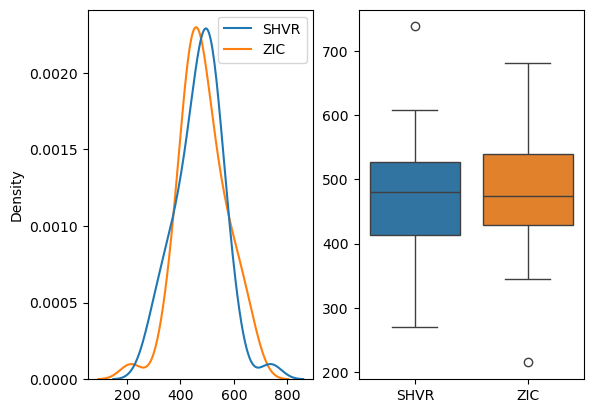

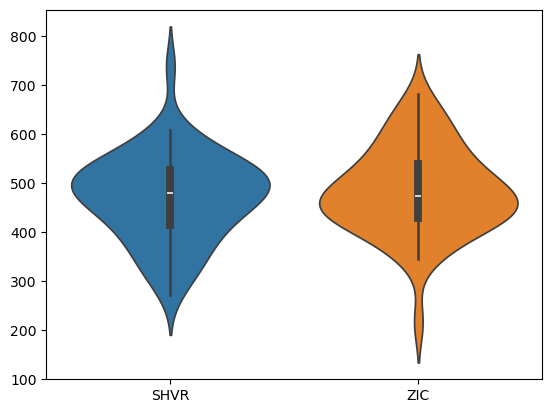

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.6242735141471026). There is not enough evidence to suggest the groups have a different population mean
21.750595569610596


In [7]:
import time
t1 = time.time()
cwhelpers.run_experiment(50, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
print(time.time() - t1)

In [ ]:
# for i in tqdm(range(n)):
#     random.seed(100) # changing the seed value will give us different seqences of random numbers
#     trial_id = 'smith_chart_'
#     market_session(trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose)
run_experiment(50, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

In [ ]:
run_experiment(500, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

### Part B

In [11]:
def part_b(n):
    r_list = list(range(10, 91, 10))
    for r in r_list:
        r_vals = (r, 100-r)
        seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
        buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
        traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
        print(f'R: {r} {seller_specs}')
        run_experiment(n, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

        print('------------------------------------------------------------------------------------------------------------------------------')

R: 10 [('SHVR', 2), ('ZIC', 18)]
n: 50
SHVR: mean=532.54 std=266.50000650917013
ZIC: mean=469.34 std=30.026933488018347
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.08104146271944046). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.07202393561601639). There is enough evidence to suggest the data is normally distributed


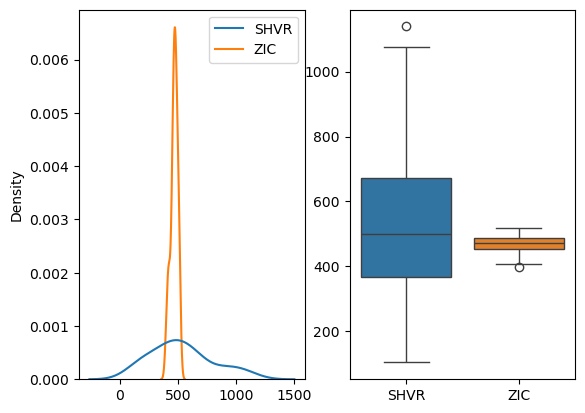

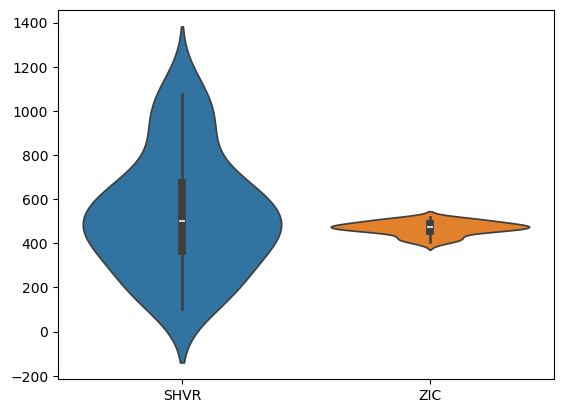

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.13817518239302715). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 20 [('SHVR', 4), ('ZIC', 16)]
n: 50
SHVR: mean=507.28 std=173.1136278958572
ZIC: mean=468.1 std=43.6120419618439
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.387091726064682). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.4137516915798187). There is enough evidence to suggest the data is normally distributed


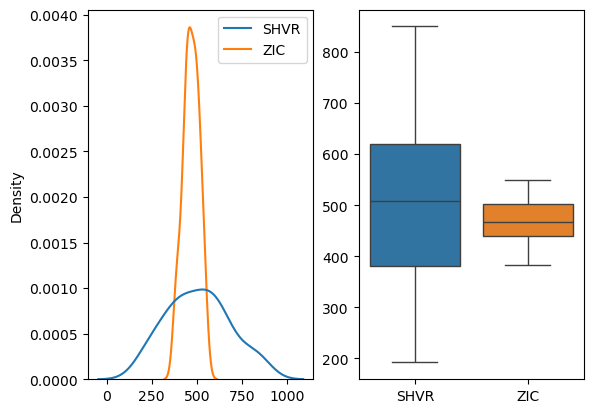

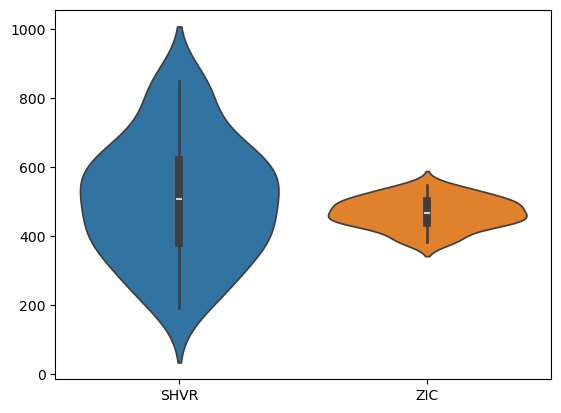

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.20712069401593572). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 30 [('SHVR', 6), ('ZIC', 14)]
n: 50
SHVR: mean=498.48 std=140.4683478036738
ZIC: mean=466.92 std=60.44928385322152
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.893971860408783). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.9034130573272705). There is enough evidence to suggest the data is normally distributed


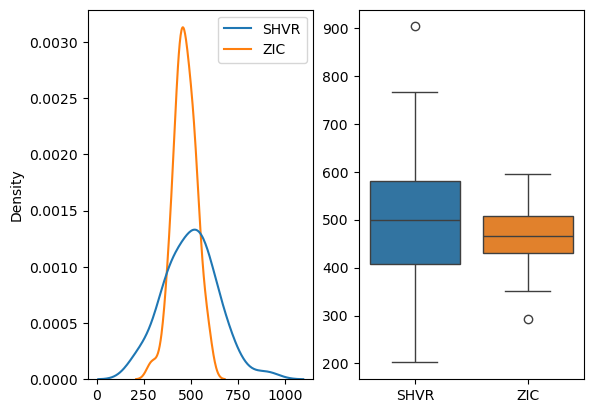

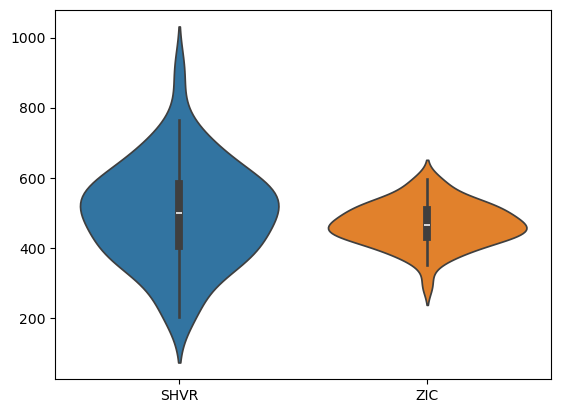

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.27207846817018533). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 40 [('SHVR', 8), ('ZIC', 12)]
n: 50
SHVR: mean=485.8 std=118.1051071145131
ZIC: mean=470.56 std=78.70071441212966
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.2568674683570862). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.26808634400367737). There is enough evidence to suggest the data is normally distributed


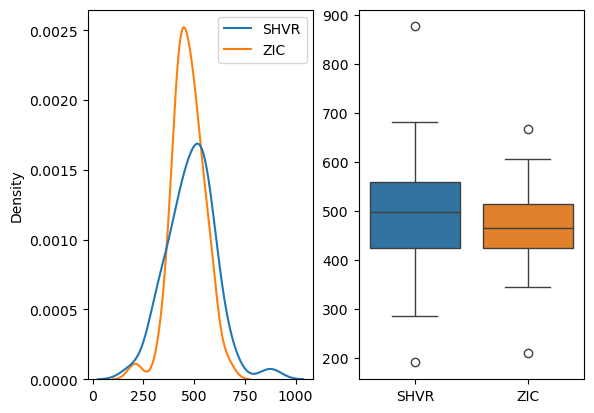

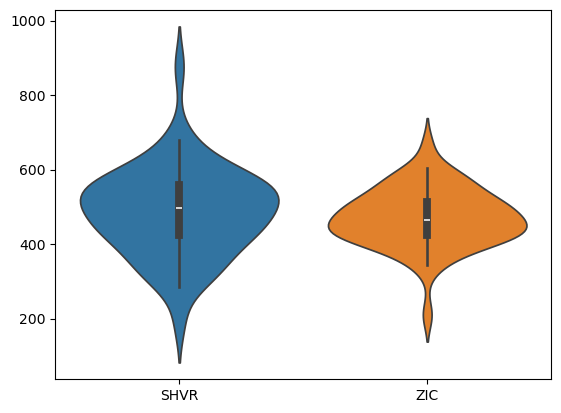

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.5864586802627515). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 50 [('SHVR', 10), ('ZIC', 10)]
n: 50
SHVR: mean=471.04 std=88.6432796122084
ZIC: mean=483.42 std=88.9590802514486
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.4868687093257904). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.4475575089454651). There is enough evidence to suggest the data is normally distributed


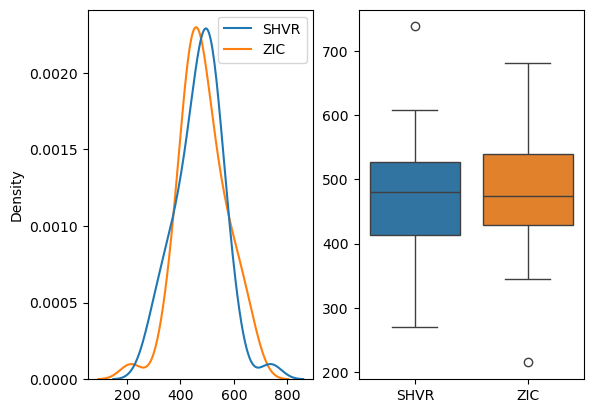

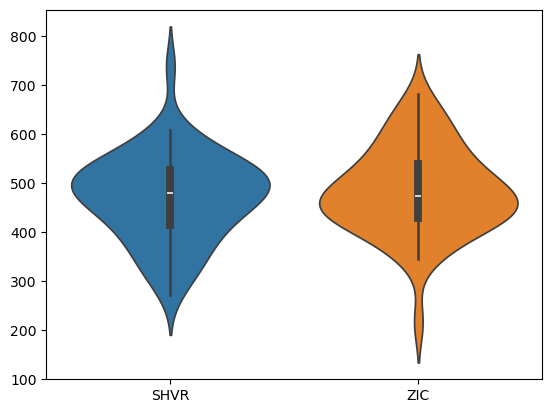

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.6242735141471026). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 60 [('SHVR', 12), ('ZIC', 8)]
n: 50
SHVR: mean=464.54 std=73.94543216977983
ZIC: mean=497.02 std=111.5999579401574
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.34599569439888). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.3174702227115631). There is enough evidence to suggest the data is normally distributed


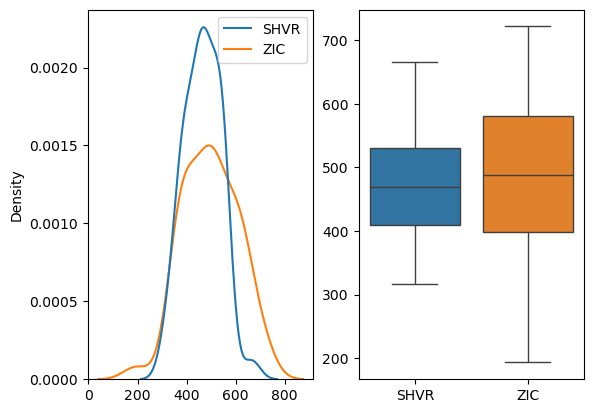

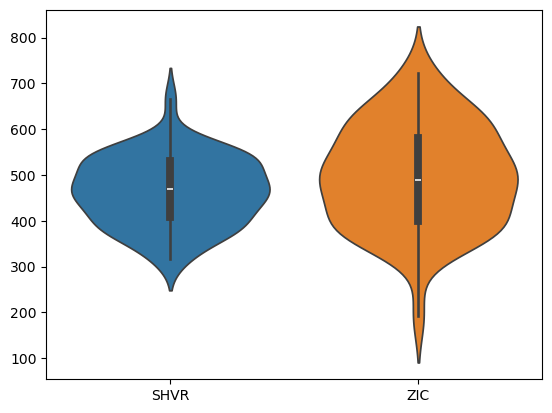

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.2216735018592181). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 70 [('SHVR', 14), ('ZIC', 6)]
n: 50
SHVR: mean=467.66 std=66.0941227434368
ZIC: mean=502.24 std=154.64845717343078
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.3684243857860565). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.36490267515182495). There is enough evidence to suggest the data is normally distributed


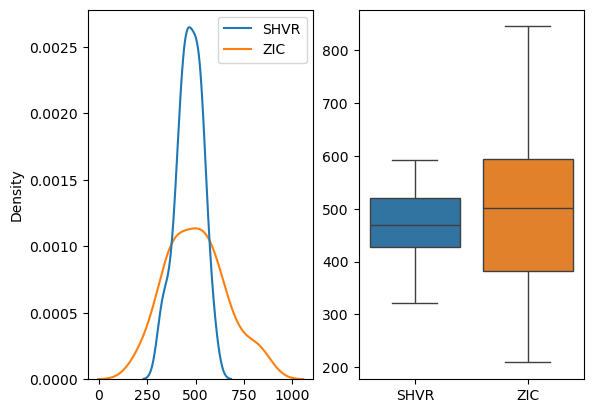

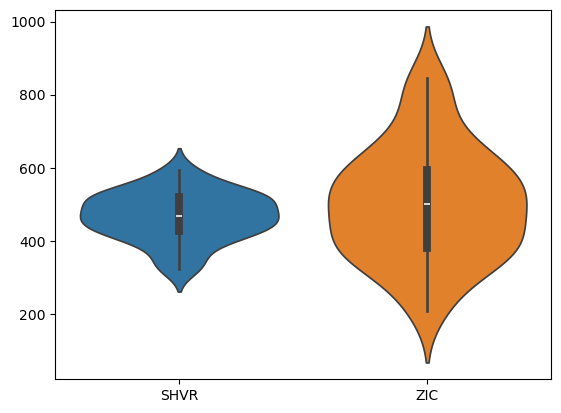

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.2733904302094769). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 80 [('SHVR', 16), ('ZIC', 4)]
n: 50
SHVR: mean=460.62 std=42.6853174584729
ZIC: mean=549.1 std=171.02157042613194
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.268600195646286). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.25921323895454407). There is enough evidence to suggest the data is normally distributed


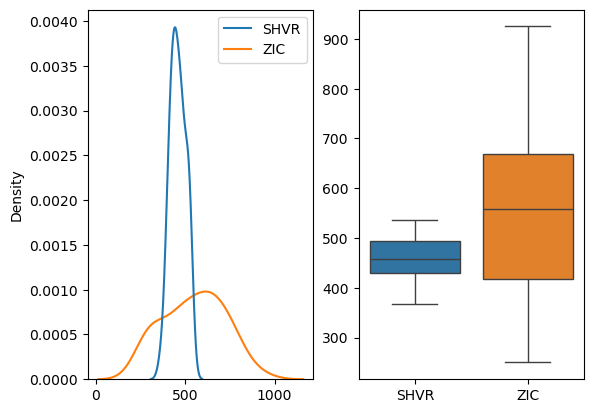

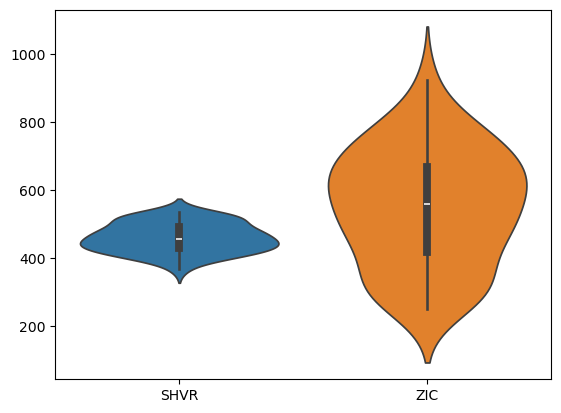

There are 2 distributions. Therefore using paired t-test
Reject null hypothesis (p=0.005168244779719084). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 90 [('SHVR', 18), ('ZIC', 2)]
n: 50
SHVR: mean=465.88 std=30.290862096193504
ZIC: mean=591.14 std=273.3323468540354
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.28894129395484924). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.30259209871292114). There is enough evidence to suggest the data is normally distributed


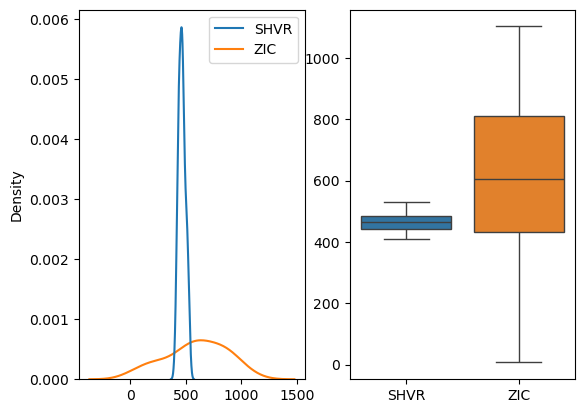

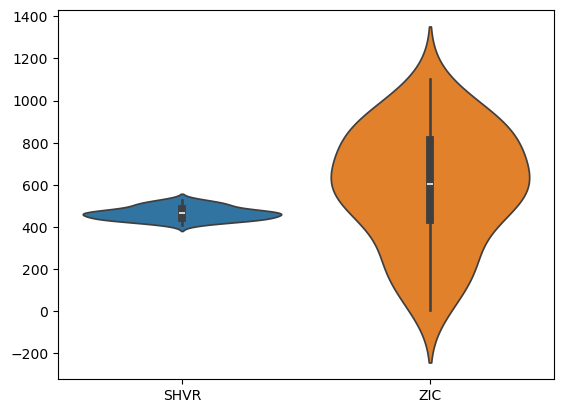

There are 2 distributions. Therefore using paired t-test
Reject null hypothesis (p=0.005317366325669718). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------


In [12]:
part_b(50)

R: 10 [('SHVR', 2), ('ZIC', 18)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=519.09 std=264.5882533061042
ZIC: mean=470.816 std=29.63495579902932
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Reject null hypothesis (p=3.4132721538071564e-08). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Reject null hypothesis (p=3.7374913830490186e-08). There is enough evidence to suggest the data is not normally distributed


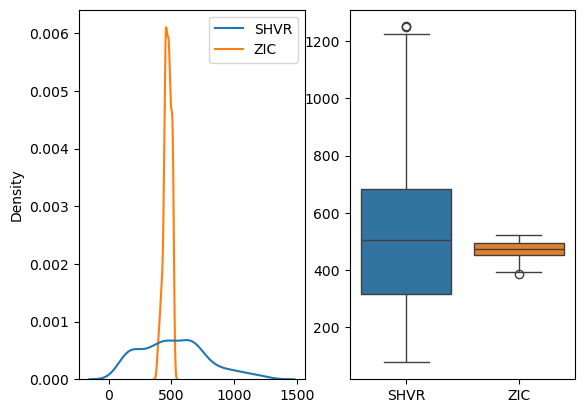

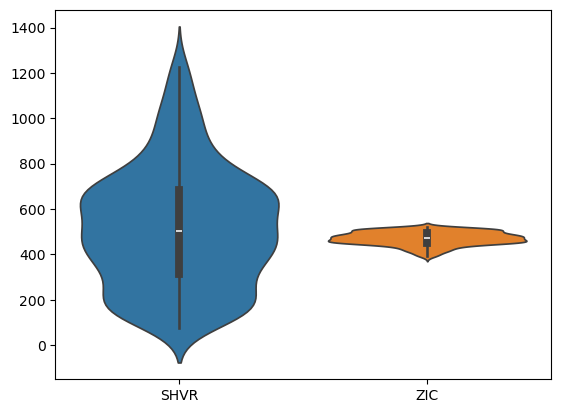

There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Reject null hypothesis (p=0.00903849962769301). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 20 [('SHVR', 4), ('ZIC', 16)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=503.386 std=176.3377071926363
ZIC: mean=469.038 std=44.39926965945035
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Reject null hypothesis (p=0.0011529207695275545). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Reject null hypothesis (p=0.0011998119298368692). There is enough evidence to suggest the data is not normally distributed


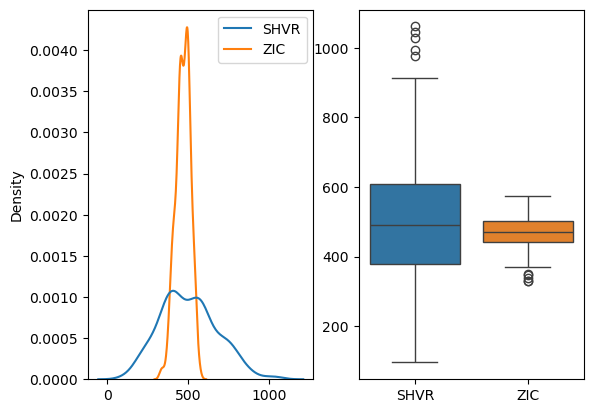

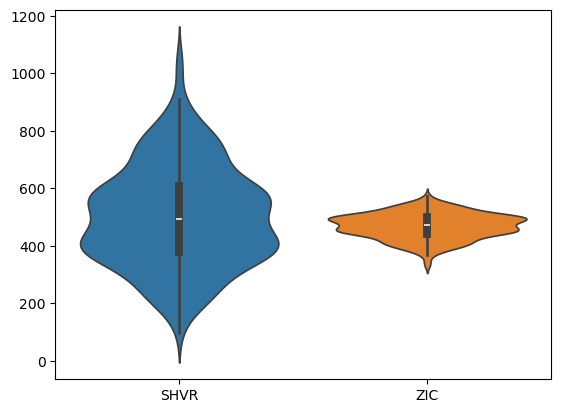

There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Reject null hypothesis (p=0.0057839371545146704). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 30 [('SHVR', 6), ('ZIC', 14)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=486.428 std=136.86104891246026
ZIC: mean=471.998 std=58.929919963749064
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.49346843361854553). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.5231310725212097). There is enough evidence to suggest the data is normally distributed


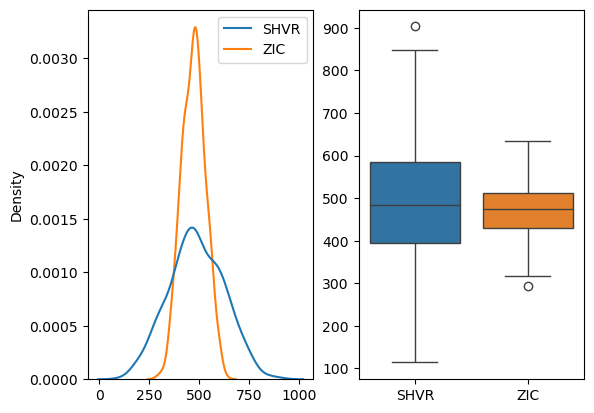

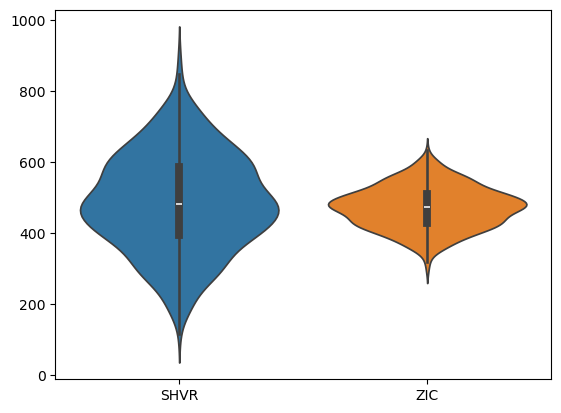

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.09995603974215336). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 40 [('SHVR', 8), ('ZIC', 12)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=476.478 std=112.40538892294194
ZIC: mean=476.922 std=75.22516578336182
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.554750919342041). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.5640385746955872). There is enough evidence to suggest the data is normally distributed


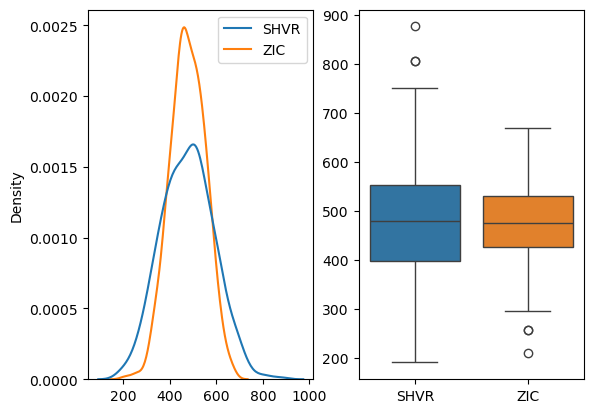

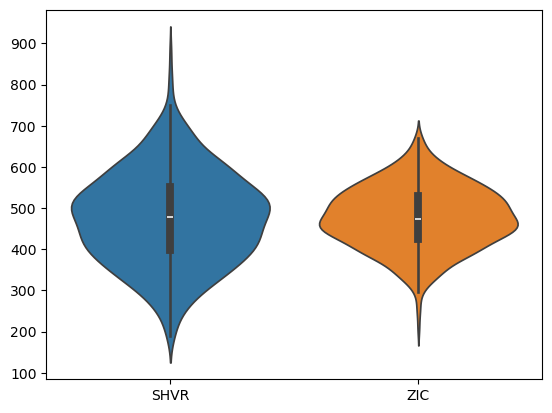

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.9578196078925926). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 50 [('SHVR', 10), ('ZIC', 10)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=473.482 std=96.51904230282288
ZIC: mean=480.828 std=97.01155033188365
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.40020692348480225). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.3984619975090027). There is enough evidence to suggest the data is normally distributed


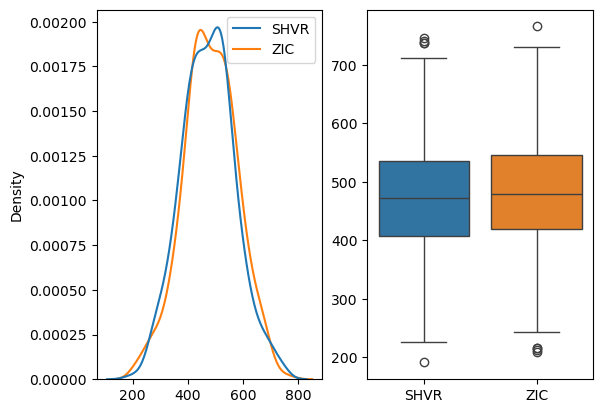

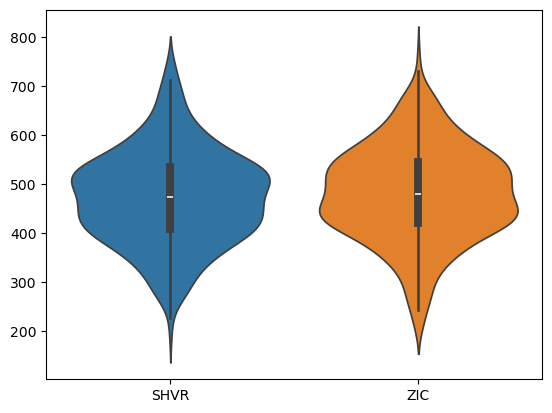

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.3963984692917647). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------
R: 60 [('SHVR', 12), ('ZIC', 8)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=469.232 std=79.34916986027659
ZIC: mean=489.904 std=119.75617674147529
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.26163116097450256). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.2642878592014313). There is enough evidence to suggest the data is normally distributed


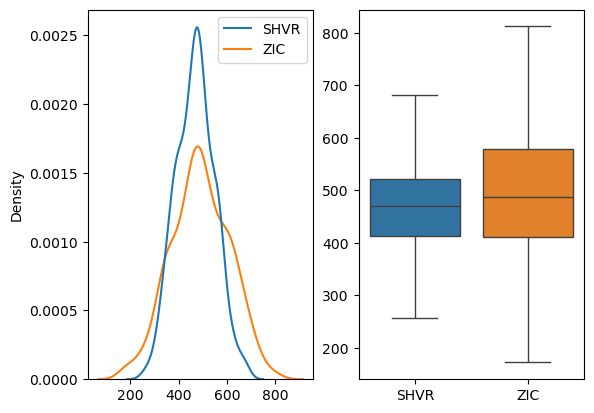

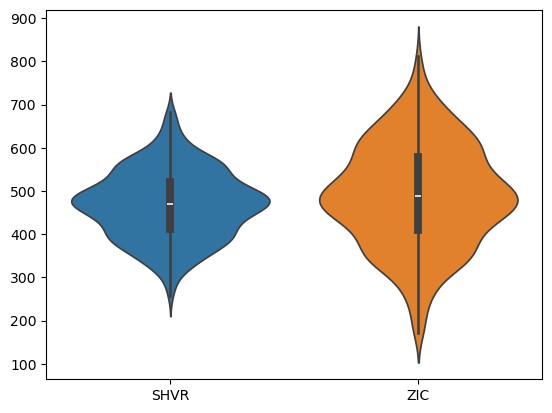

There are 2 distributions. Therefore using paired t-test
Reject null hypothesis (p=0.02065238727373824). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 70 [('SHVR', 14), ('ZIC', 6)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=471.874 std=65.58494410905277
ZIC: mean=492.212 std=153.4697135004945
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.15117891132831573). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.19251887500286102). There is enough evidence to suggest the data is normally distributed


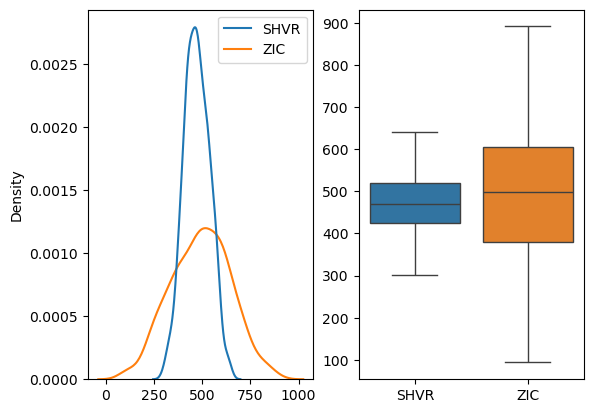

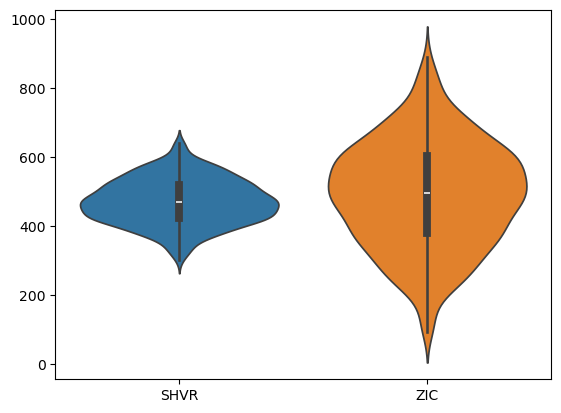

There are 2 distributions. Therefore using paired t-test
Reject null hypothesis (p=0.03839635840929198). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 80 [('SHVR', 16), ('ZIC', 4)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=473.176 std=49.70886204623744
ZIC: mean=498.658 std=199.19533779986514
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Do not reject null hypothesis (p=0.2749834954738617). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.293950617313385). There is enough evidence to suggest the data is normally distributed


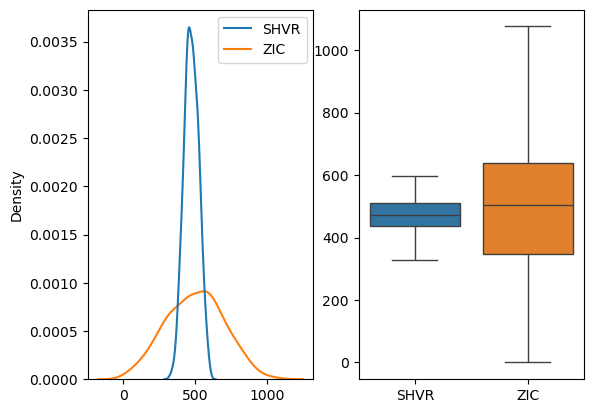

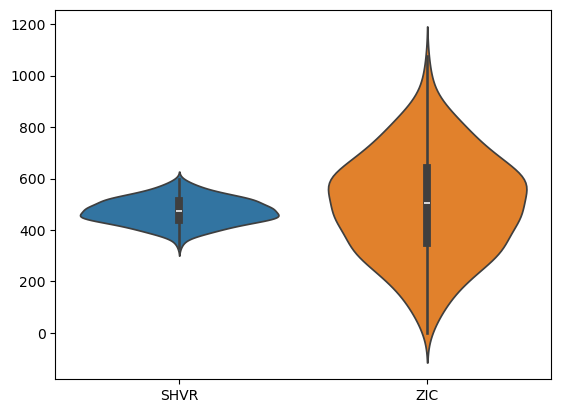

There are 2 distributions. Therefore using paired t-test
Reject null hypothesis (p=0.022482767339640636). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 90 [('SHVR', 18), ('ZIC', 2)]
n: 500
50
100
150
200
250
300
350
400
450
SHVR: mean=475.53 std=33.078171516299435
ZIC: mean=504.002 std=298.12451500823914
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: SHVR. Reject null hypothesis (p=1.1349244459779584e-06). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Reject null hypothesis (p=8.33496642371756e-07). There is enough evidence to suggest the data is not normally distributed


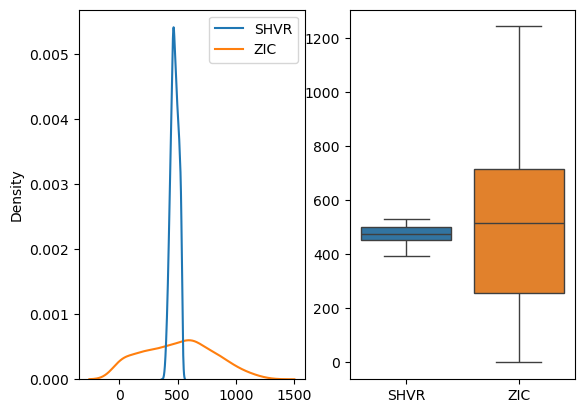

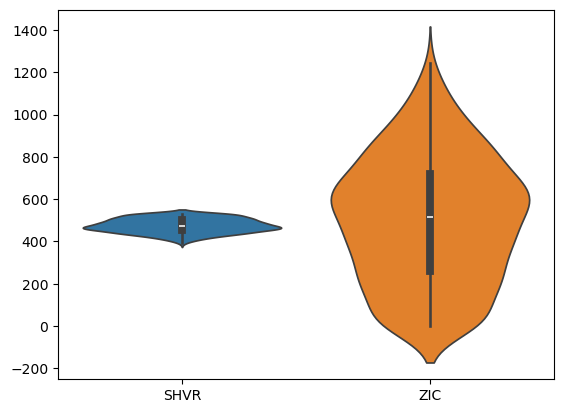

There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Do not reject null hypothesis (p=0.09751519075965111). There is not enough evidence to suggest the groups have a different population mean
------------------------------------------------------------------------------------------------------------------------------


In [13]:
part_b(500)

### Part C

In [14]:
import time
def part_c(n):
    algos = ('SHVR', 'GVWY', 'ZIC', 'ZIP')
    ratios_list = [[25, 25, 25, 25], [40,20,20,20], [10,30,30,30], [70,10,10,10]]
    n_vals = [n]
    for n in n_vals:
        for i in range(len(ratios_list)):
            for j in range(len(ratios_list[i])):
                seller_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                buyer_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'periodic'}
                print(seller_specs)
                run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
                print('-----------------------------------------------------------------------------------------------------')
                if len(set(ratios_list[i])) == 1: # no need to permute if all elements are equal
                    break
                ratios_list[i].append(ratios_list[i].pop(0)) # rotates by 1
            print(f'time: {time.time()}')

[('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
n: 50
GVWY: mean=444.76 std=134.0760612640513
SHVR: mean=461.22 std=165.0038082430035
ZIC: mean=547.68 std=166.65073338805178
ZIP: mean=243.74 std=101.03804294645153
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.40790387988090515). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Reject null hypothesis (p=0.009932128712534904). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.42184895277023315). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Reject null hypothesis (p=0.03809478133916855). There is enough evidence to suggest the data is not normally distributed


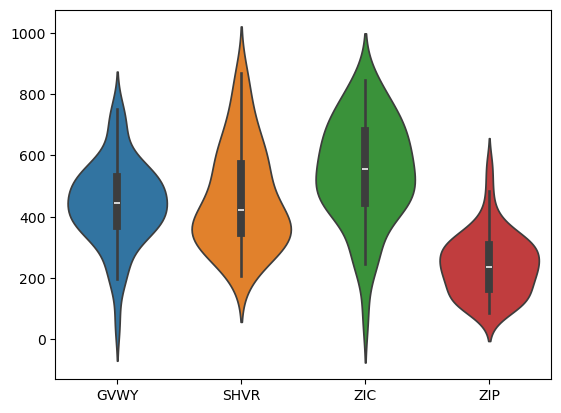

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=4.386098095714454e-13). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 0.009706327296137511), ('GVWY', 'ZIP', 3.5421123811829602e-09), ('SHVR', 'ZIP', 2.948956634440947e-09), ('ZIC', 'ZIP', 1.213216194173583e-10)]
-----------------------------------------------------------------------------------------------------
-29.791967153549194


C:\Users\ge20118\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [15]:
import time
t1 = time.time()
algos = ('SHVR', 'GVWY', 'ZIC', 'ZIP')
ratios_list = [[25, 25, 25, 25]]
n_vals = [50]
for n in n_vals:
    for i in range(len(ratios_list)):
        for j in range(len(ratios_list[i])):
            seller_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
            buyer_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
            traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
            order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'periodic'}
            print(seller_specs)
            run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
            print('-----------------------------------------------------------------------------------------------------')
            if len(set(ratios_list[i])) == 1: # no need to permute if all elements are equal
                break
            ratios_list[i].append(ratios_list[i].pop(0)) # rotates by 1
t2 = time.time()
print(t1 -t2)

[('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
n: 50
GVWY: mean=444.76 std=134.0760612640513
SHVR: mean=461.22 std=165.0038082430035
ZIC: mean=547.68 std=166.65073338805178
ZIP: mean=243.74 std=101.03804294645153
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.40790387988090515). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Reject null hypothesis (p=0.009932128712534904). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.42184895277023315). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Reject null hypothesis (p=0.03809478133916855). There is enough evidence to suggest the data is not normally distributed


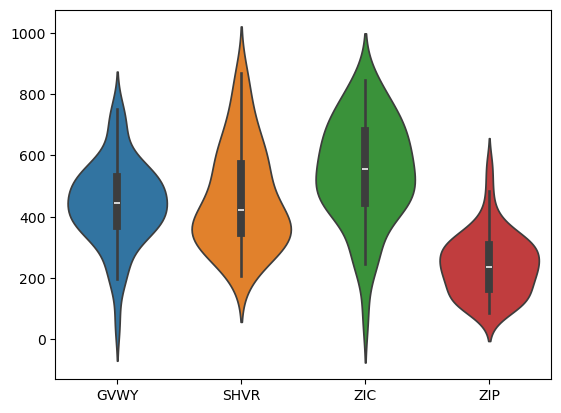

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=4.386098095714454e-13). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 0.009706327296137511), ('GVWY', 'ZIP', 3.5421123811829602e-09), ('SHVR', 'ZIP', 2.948956634440947e-09), ('ZIC', 'ZIP', 1.213216194173583e-10)]
-----------------------------------------------------------------------------------------------------
time: 1701283958.5029373
[('SHVR', 8), ('GVWY', 4), ('ZIC', 4), ('ZIP', 4)]
n: 50


C:\Users\ge20118\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


GVWY: mean=471.36 std=121.85350187158079
SHVR: mean=471.18 std=98.11939623931319
ZIC: mean=502.88 std=168.4070190984706
ZIP: mean=265.04 std=116.71296729452934
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.23699767887592316). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.23304611444473267). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.5016714334487915). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Do not reject null hypothesis (p=0.2810673713684082). There is enough evidence to suggest the data is normally distributed


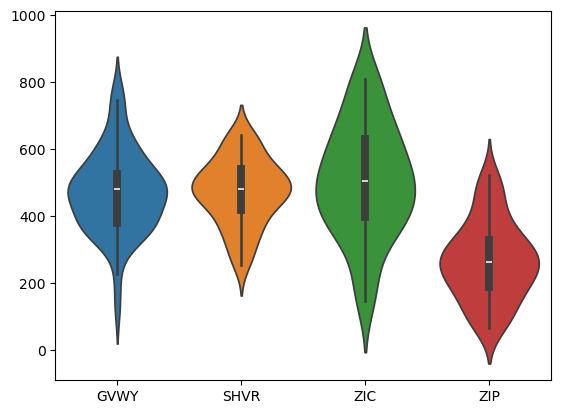

Testing for sphericity with Mauchlys Test
Do not reject null hyptothesis (p=0.1672023341824115). There is enough evidence to suggest the samples have sphericity
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=1.0090720948986081e-14). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 4.792921145112098e-10), ('SHVR', 'ZIP', 5.297749961686879e-10), ('ZIC', 'ZIP', 1.7357767889965716e-08)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 4), ('ZIC', 4), ('ZIP', 8)]
n: 50
GVWY: mean=366.16 std=162.9129428215435
SHVR: mean=498.38 std=184.14799837663844
ZIC: mean=463.52 std=198.59714530286934
ZIP: mean=194.02 std=80.17747915259811
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.49636587500572205). There is enough evidence to suggest the da

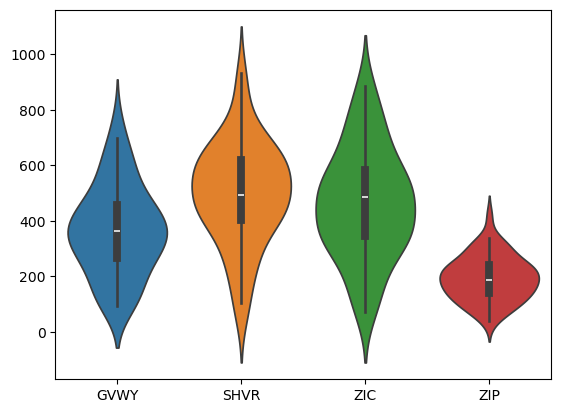

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=0.00025569174211304745). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=4.597326039479518e-12). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.003177457257979531), ('GVWY', 'ZIC', 0.021069606006716188), ('GVWY', 'ZIP', 1.2453631561507745e-07), ('SHVR', 'ZIP', 5.080224887049567e-13), ('ZIC', 'ZIP', 9.656728457212744e-10)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 4), ('ZIC', 8), ('ZIP', 4)]
n: 50
GVWY: mean=474.26 std=191.00088791331171
SHVR: mean=444.46 std=187.19325493691687
ZIC: mean=496.6 std=104.6260591100418
ZIP: mean=297.02 std=134.46591101275368
Check each column if the data is normally distrubuted with the shapiro wil

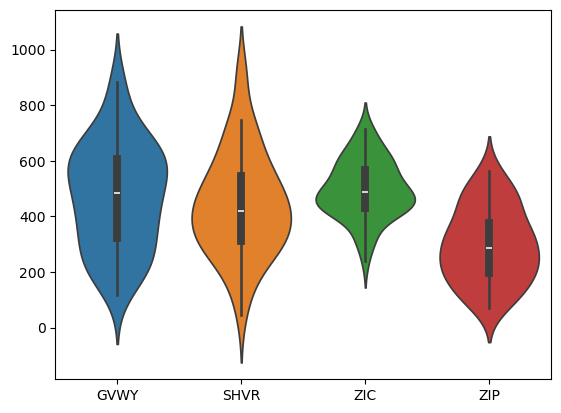

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=0.012433736671692924). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=1.9422750443028817e-06). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 5.788149396050746e-05), ('SHVR', 'ZIP', 9.161406219050538e-05), ('ZIC', 'ZIP', 1.0703392149037369e-07)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 8), ('ZIC', 4), ('ZIP', 4)]
n: 50
GVWY: mean=484.78 std=92.0969520202953
SHVR: mean=431.82 std=189.5063070405924
ZIC: mean=501.68 std=162.76005125863745
ZIP: mean=232.56 std=104.31079150543245
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.05654429271817207). T

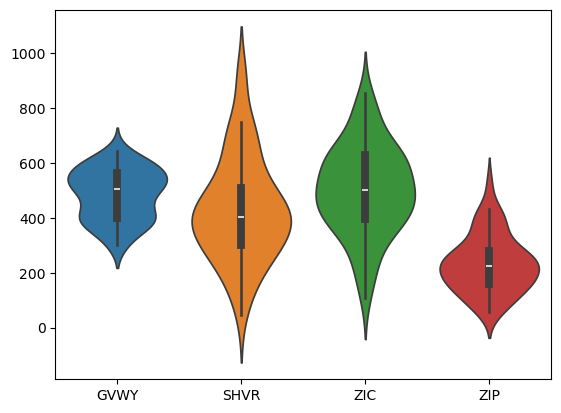

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=0.0016518256088625118). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=1.1621331579147345e-12). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 6.556304260379408e-15), ('SHVR', 'ZIP', 1.4842774114709093e-06), ('ZIC', 'ZIP', 1.3966107572756823e-10)]
-----------------------------------------------------------------------------------------------------
time: 1701284084.6663816
[('SHVR', 2), ('GVWY', 6), ('ZIC', 6), ('ZIP', 6)]
n: 50
GVWY: mean=428.28 std=110.74571719733014
SHVR: mean=444.58 std=247.62802007553714
ZIC: mean=535.26 std=134.1400136622407
ZIP: mean=186.6 std=71.89504822436434
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis

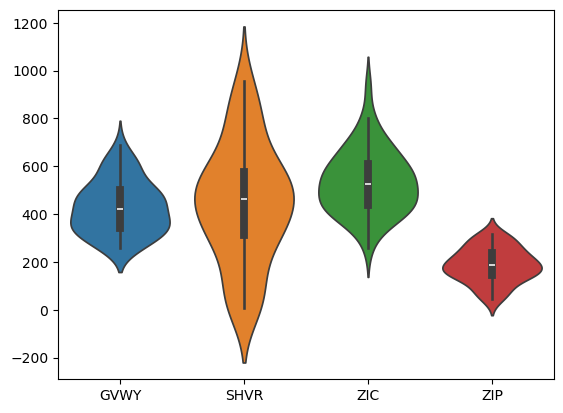

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=4.554789386943095e-08). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=7.316582447667616e-14). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 0.0025240987593823645), ('GVWY', 'ZIP', 5.175150252197118e-16), ('SHVR', 'ZIC', 0.04897290545274602), ('SHVR', 'ZIP', 1.0476981723687592e-08), ('ZIC', 'ZIP', 1.6131693486939645e-18)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 6), ('ZIC', 6), ('ZIP', 2)]
n: 50
GVWY: mean=446.98 std=123.72014007923079
SHVR: mean=487.06 std=151.1439927043488
ZIC: mean=500.04 std=131.9110646594585
ZIP: mean=283.26 std=136.04213182927214
Check each column if the data is normally distrubuted with the shapiro wilk

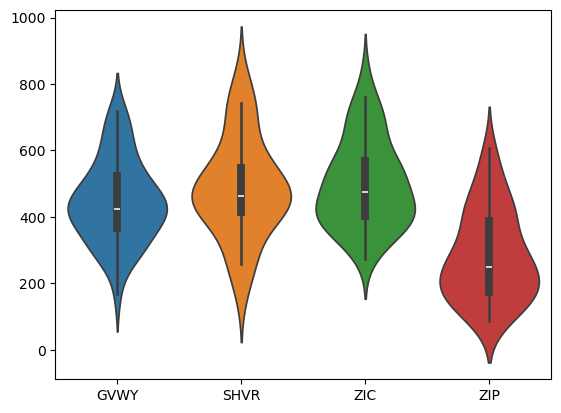

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=3.849120150910064e-10). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 4.198179136386998e-05), ('SHVR', 'ZIP', 3.1910687425806827e-09), ('ZIC', 'ZIP', 1.0623386614838637e-08)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 6), ('ZIC', 2), ('ZIP', 6)]
n: 50


C:\Users\ge20118\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


GVWY: mean=462.9 std=125.37295382585675
SHVR: mean=450.5 std=125.51709372163829
ZIC: mean=602.58 std=270.2814927184665
ZIP: mean=225.82 std=75.1492908706885
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.6904751062393188). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.9448564052581787). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.4046367406845093). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Do not reject null hypothesis (p=0.3038273751735687). There is enough evidence to suggest the data is normally distributed


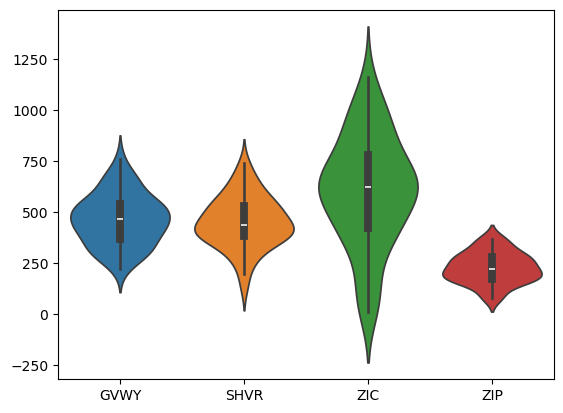

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=1.1546169880909276e-08). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=3.3025820833334495e-12). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 0.00846741439813773), ('GVWY', 'ZIP', 9.858051140982457e-14), ('SHVR', 'ZIC', 0.003742909627218767), ('SHVR', 'ZIP', 1.3521767278174706e-12), ('ZIC', 'ZIP', 5.0301626259734426e-11)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 2), ('ZIC', 6), ('ZIP', 6)]
n: 50
GVWY: mean=426.6 std=234.42339160291203
SHVR: mean=464.6 std=124.2903119018255
ZIC: mean=521.44 std=132.79386511524126
ZIP: mean=246.86 std=82.93272660932558
Check each column if the data is normally distrubuted with the shapiro wilk 

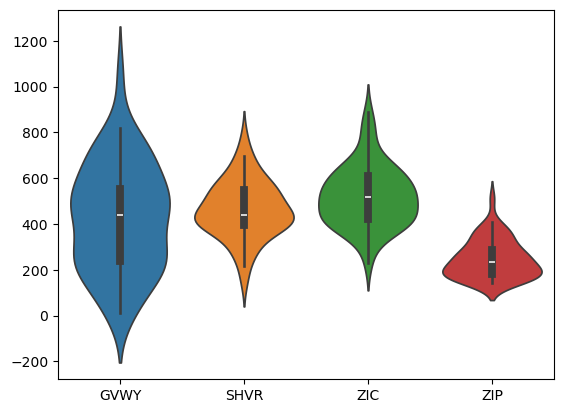

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=5.010633014899264e-12). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 8.924174345281699e-06), ('SHVR', 'ZIP', 2.4802382370125997e-10), ('ZIC', 'ZIP', 2.531308496145357e-11)]
-----------------------------------------------------------------------------------------------------
time: 1701284208.7818148
[('SHVR', 14), ('GVWY', 2), ('ZIC', 2), ('ZIP', 2)]
n: 50


C:\Users\ge20118\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


GVWY: mean=480.52 std=261.1401406548302
SHVR: mean=466.82 std=48.48550803895859
ZIC: mean=558.78 std=244.32416489373378
ZIP: mean=346.42 std=170.94552062106854
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=0.02413027733564377). There is enough evidence to suggest the data is not normally distributed
Condition: SHVR. Reject null hypothesis (p=0.021681124344468117). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.7484522461891174). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Do not reject null hypothesis (p=0.10694900155067444). There is enough evidence to suggest the data is normally distributed


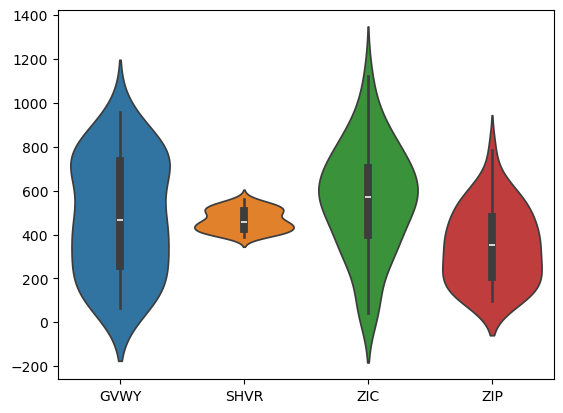

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=0.0009146884240550351). There is sufficient evidence to suggest groups have a population different mean
[('SHVR', 'ZIP', 0.000595173240780511), ('ZIC', 'ZIP', 4.2669623706359516e-05)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 2), ('ZIC', 2), ('ZIP', 14)]
n: 50


C:\Users\ge20118\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


GVWY: mean=470.2 std=266.6576188941275
SHVR: mean=486.3 std=296.14525186820345
ZIC: mean=439.06 std=277.35105655365476
ZIP: mean=130.14 std=62.99401008129621
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.44041621685028076). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Reject null hypothesis (p=0.043349191546440125). There is enough evidence to suggest the data is not normally distributed
Condition: ZIC. Reject null hypothesis (p=0.0381862111389637). There is enough evidence to suggest the data is not normally distributed
Condition: ZIP. Reject null hypothesis (p=0.005571360234171152). There is enough evidence to suggest the data is not normally distributed


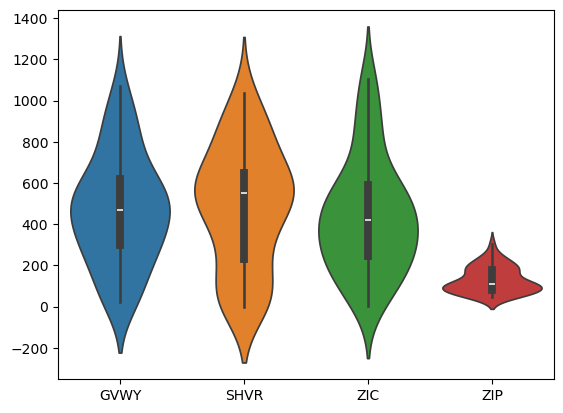

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=8.828072796873381e-10). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 2.042206403984892e-10), ('SHVR', 'ZIP', 3.5421123811829602e-09), ('ZIC', 'ZIP', 3.168931783648077e-10)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 2), ('ZIC', 14), ('ZIP', 2)]
n: 50
GVWY: mean=449.36 std=258.8769907244184
SHVR: mean=466.3 std=268.27204057654245
ZIC: mean=481.42 std=63.413798150862775
ZIP: mean=470.88 std=227.28689413359925
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.23543822765350342). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.10196242481470108). There is enough evidence to suggest the data is normally distributed
Conditio

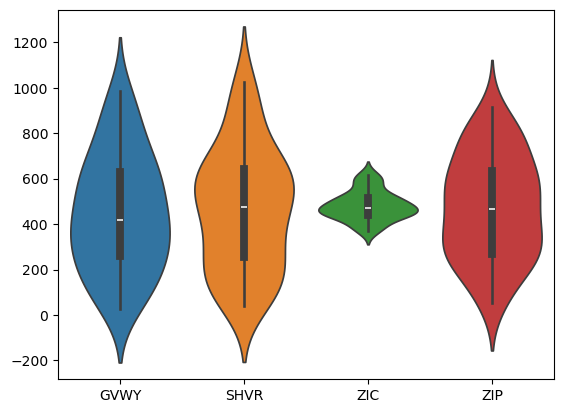

Testing for sphericity with Mauchlys Test
Do not reject null hyptothesis (p=0.1874157643125167). There is enough evidence to suggest the samples have sphericity
There are 4 distributions. Therefore using Repeated measures ANOVA test
Do not reject null hypothesis (p=0.9178541982725941). There is not enough evidence to suggest the groups have a different population mean
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 14), ('ZIC', 2), ('ZIP', 2)]
n: 50
GVWY: mean=469.72 std=59.457424314566886
SHVR: mean=431.18 std=272.9896230366903
ZIC: mean=550.98 std=242.4700688450315
ZIP: mean=224.44 std=108.80185322551323
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.5763913989067078). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.07531320303678513). There is enough

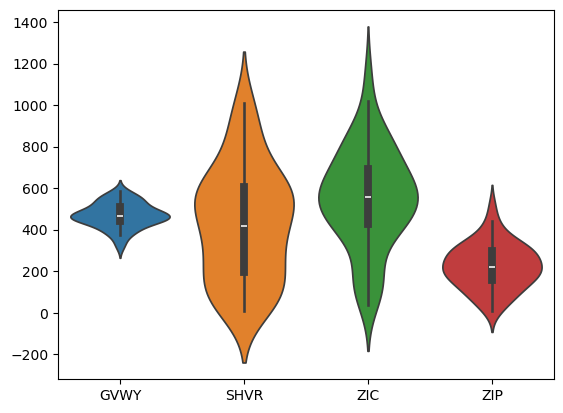

Testing for sphericity with Mauchlys Test
Reject null hyptothesis (p=1.0160684047080932e-07). There is insufficient evidence to suggest the samples have sphericity. Applying Greenhouse-Gessier correction.
There are 4 distributions. Therefore using Repeated measures ANOVA test
Reject null hypothesis (p=1.2565418068688624e-09). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIP', 9.747378352156857e-16), ('SHVR', 'ZIP', 4.576568184460199e-05), ('ZIC', 'ZIP', 1.4352240690993002e-10)]
-----------------------------------------------------------------------------------------------------
time: 1701284345.264576


In [16]:
part_c(50)

[('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=449.104 std=149.6596847065131
SHVR: mean=479.924 std=161.10223488259982
ZIC: mean=493.616 std=160.71305459057035
ZIP: mean=242.508 std=95.08973683896811
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.716498851776123). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.5403762459754944). There is enough evidence to suggest the data is normally distributed
Condition: ZIC. Do not reject null hypothesis (p=0.20652112364768982). There is enough evidence to suggest the data is normally distributed
Condition: ZIP. Reject null hypothesis (p=2.0111802001565593e-08). There is enough evidence to suggest the data is not normally distributed


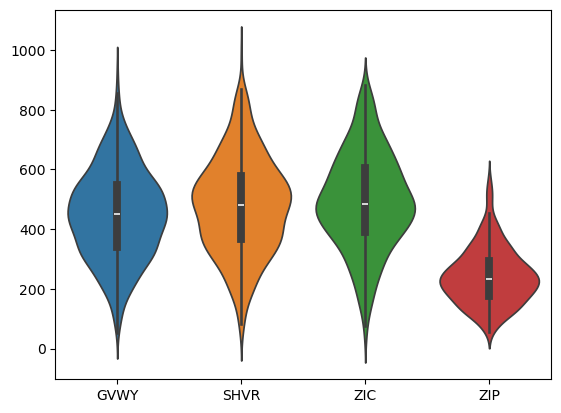

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=7.927304259246568e-109). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.018452898518823285), ('GVWY', 'ZIC', 0.0003948368791802236), ('GVWY', 'ZIP', 1.4236954280924852e-63), ('SHVR', 'ZIP', 2.1777012388575354e-66), ('ZIC', 'ZIP', 1.4849434822148938e-68)]
-----------------------------------------------------------------------------------------------------
time: 1701284647.4048064
[('SHVR', 8), ('GVWY', 4), ('ZIC', 4), ('ZIP', 4)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=442.62 std=158.3204545618327
SHVR: mean=476.67 std=117.16595419166478
ZIC: mean=507.168 std=186.3637590234612
ZIP: mean=271.038 std=114.12648362465684
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.17868643999099731). There is enough evidence to suggest the data is normally distributed
Cond

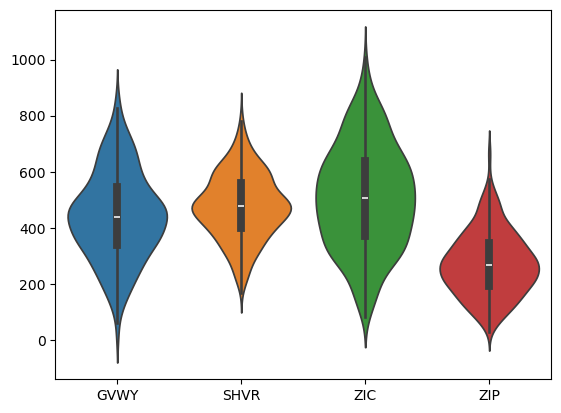

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=7.078139986214795e-85). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.002526884616167805), ('GVWY', 'ZIC', 6.970927143221212e-07), ('GVWY', 'ZIP', 4.50439329851202e-50), ('SHVR', 'ZIC', 0.0227105010226153), ('SHVR', 'ZIP', 1.1647324046305863e-60), ('ZIC', 'ZIP', 2.5548884571109853e-58)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 4), ('ZIC', 4), ('ZIP', 8)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=440.194 std=174.50855232242148
SHVR: mean=479.398 std=192.17369501081097
ZIC: mean=484.188 std=189.72268723614528
ZIP: mean=189.284 std=68.92579251446799
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.18914742767810822). There is enough evidence to suggest the data is normally dist

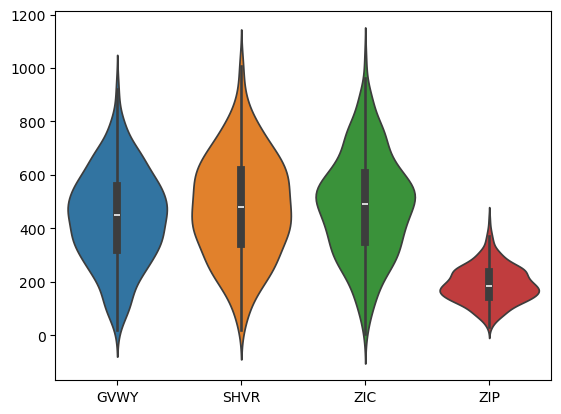

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=1.3317999842223244e-128). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.011437200248117953), ('GVWY', 'ZIC', 0.005025727328527418), ('GVWY', 'ZIP', 5.160486746600001e-72), ('SHVR', 'ZIP', 4.137795311518325e-75), ('ZIC', 'ZIP', 3.804314049466166e-73)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 4), ('ZIC', 8), ('ZIP', 4)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=442.872 std=175.07262625816145
SHVR: mean=480.336 std=195.57626454789715
ZIC: mean=484.334 std=112.27468839997113
ZIP: mean=327.866 std=134.5368513558478
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=0.024125274270772934). There is enough evidence to suggest the data is not normally distributed
Condition: SHVR. Reject null hy

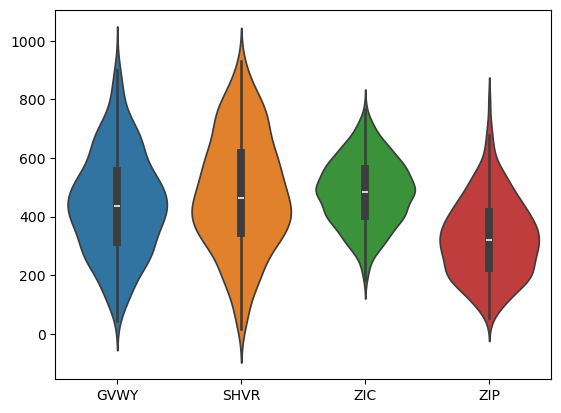

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=2.7205287489839758e-43). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.010483100573789665), ('GVWY', 'ZIC', 0.00019843260388664185), ('GVWY', 'ZIP', 2.5643649827723292e-21), ('SHVR', 'ZIP', 1.460500174476104e-30), ('ZIC', 'ZIP', 2.0923643465212582e-42)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 4), ('GVWY', 8), ('ZIC', 4), ('ZIP', 4)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=452.56 std=104.06369638741279
SHVR: mean=469.18 std=195.5985715755735
ZIC: mean=511.362 std=187.49563243009354
ZIP: mean=237.164 std=102.45631115451492
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.6387181282043457). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Reject null 

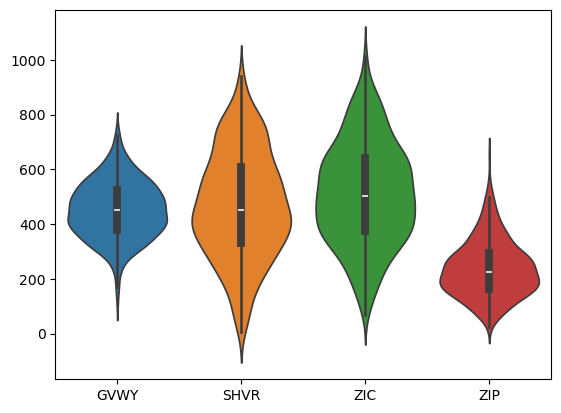

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=7.471133825408143e-107). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 3.6251845096813584e-06), ('GVWY', 'ZIP', 2.297836520882273e-71), ('SHVR', 'ZIC', 0.012951877864847767), ('SHVR', 'ZIP', 2.811764019716269e-57), ('ZIC', 'ZIP', 1.9028730821734254e-67)]
-----------------------------------------------------------------------------------------------------
time: 1701285883.6469982
[('SHVR', 2), ('GVWY', 6), ('ZIC', 6), ('ZIP', 6)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=440.834 std=134.56034861294643
SHVR: mean=458.044 std=283.337117066959
ZIC: mean=488.668 std=145.27368192939372
ZIP: mean=198.488 std=79.63832231257463
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.691642701625824). There is enough evidence to suggest the data is normally distributed
Conditi

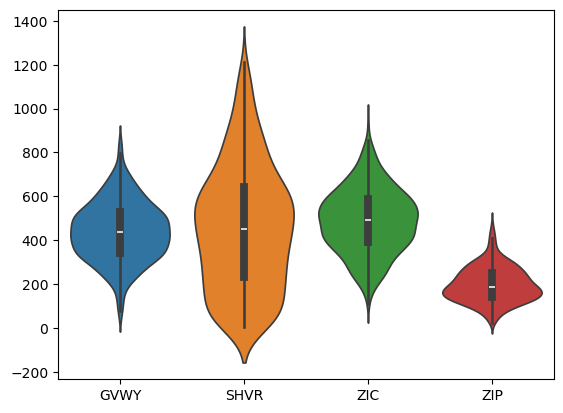

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=1.1832272741449072e-119). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 2.6430427704615298e-05), ('GVWY', 'ZIP', 9.84353584270241e-77), ('SHVR', 'ZIC', 0.030984742524398593), ('SHVR', 'ZIP', 6.270505603260755e-51), ('ZIC', 'ZIP', 2.6381188315852524e-78)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 6), ('ZIC', 6), ('ZIP', 2)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=442.874 std=126.31910051258528
SHVR: mean=485.634 std=148.9088302400059
ZIC: mean=496.142 std=145.84583590800048
ZIP: mean=301.776 std=181.16674253626786
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.23001399636268616). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reje

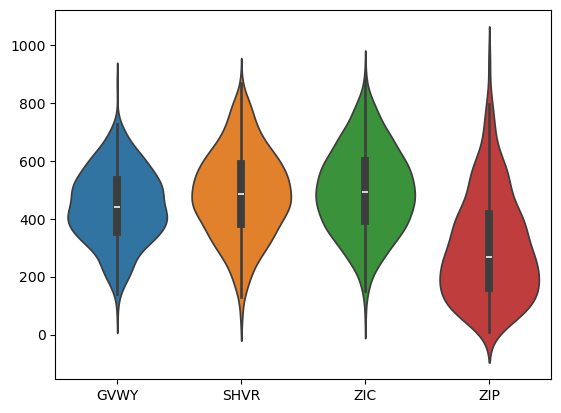

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=5.241483536219144e-56). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.00015976472853878777), ('GVWY', 'ZIC', 1.052496309228686e-06), ('GVWY', 'ZIP', 1.3353085814251424e-31), ('SHVR', 'ZIP', 5.722115967674677e-40), ('ZIC', 'ZIP', 1.2667052130009843e-41)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 6), ('ZIC', 2), ('ZIP', 6)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=448.748 std=134.8707408204571
SHVR: mean=468.254 std=138.48124636639568
ZIC: mean=504.786 std=274.8560421234787
ZIP: mean=229.876 std=84.78460640332025
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.18100231885910034). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Do not reje

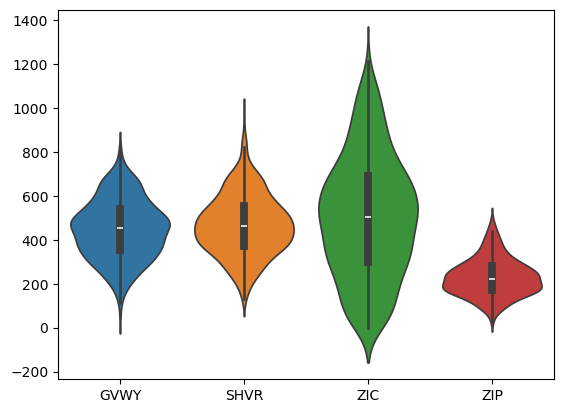

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=6.115959138234202e-104). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 0.004032702359641339), ('GVWY', 'ZIP', 1.9173405635584765e-72), ('SHVR', 'ZIP', 2.1699414062382672e-72), ('ZIC', 'ZIP', 2.7008829542452847e-53)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 6), ('GVWY', 2), ('ZIC', 6), ('ZIP', 6)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=430.102 std=255.2089395017409
SHVR: mean=476.55 std=139.27868683043513
ZIC: mean=477.894 std=145.27592006213482
ZIP: mean=255.84 std=87.7269767226124
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=1.0331986004530336e-06). There is enough evidence to suggest the data is not normally distributed
Condition: SHVR. Do not reject null hypothesis (p=0.06947296112775803).

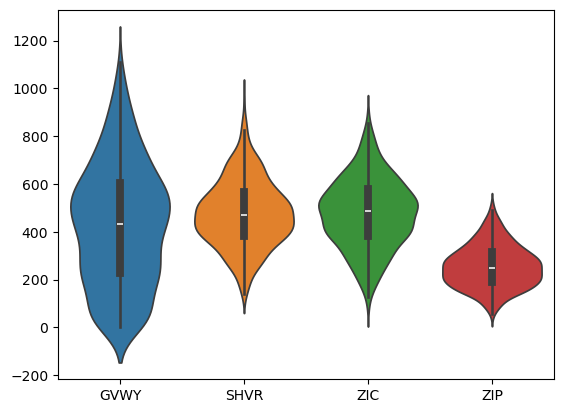

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=6.554392041490188e-90). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.002283235259476095), ('GVWY', 'ZIC', 0.0017525124849162102), ('GVWY', 'ZIP', 1.0237709155836294e-32), ('SHVR', 'ZIP', 3.062287821656746e-69), ('ZIC', 'ZIP', 4.4599559049408196e-67)]
-----------------------------------------------------------------------------------------------------
time: 1701287122.6346166
[('SHVR', 14), ('GVWY', 2), ('ZIC', 2), ('ZIP', 2)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=457.302 std=260.6238369081568
SHVR: mean=469.426 std=65.03552693356956
ZIC: mean=531.328 std=268.239977981611
ZIP: mean=357.028 std=198.8311617371772
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=2.0781751572940266e-06). There is enough evidence to suggest the data is not normally distributed
Condit

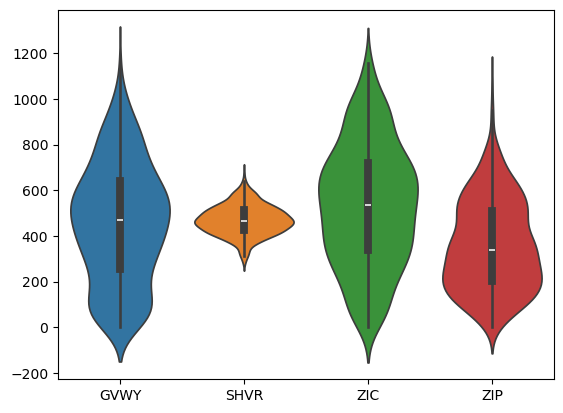

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=2.0375106482309034e-21). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 7.248038819681516e-05), ('GVWY', 'ZIP', 2.4864638070034096e-10), ('SHVR', 'ZIC', 7.597122259261954e-05), ('SHVR', 'ZIP', 1.1490664634730176e-20), ('ZIC', 'ZIP', 2.1274466614622985e-23)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 2), ('ZIC', 2), ('ZIP', 14)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=439.64 std=277.5092090764638
SHVR: mean=493.12 std=289.71724450492616
ZIC: mean=496.39 std=277.9791624015349
ZIP: mean=128.982 std=61.336661533671624
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=4.6919268470446696e-08). There is enough evidence to suggest the data is not normally distributed
Condition: SHVR. Reject null 

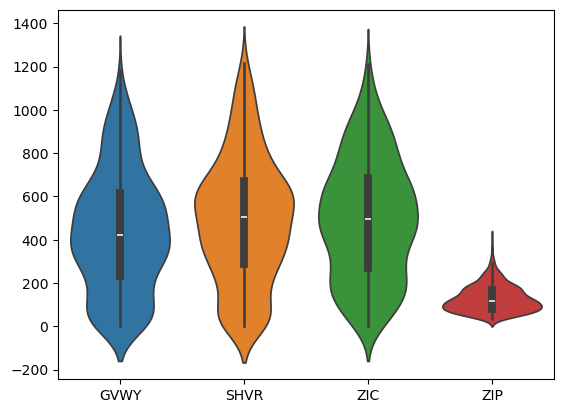

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=6.542421371478516e-100). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 0.01287689121401271), ('GVWY', 'ZIC', 0.01287689121401271), ('GVWY', 'ZIP', 1.2495563562312091e-65), ('SHVR', 'ZIP', 5.674248864717606e-71), ('ZIC', 'ZIP', 1.6043882275280072e-71)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 2), ('ZIC', 14), ('ZIP', 2)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=417.272 std=242.91524787732567
SHVR: mean=508.592 std=272.16011425553
ZIC: mean=475.348 std=58.97547888928447
ZIP: mean=501.374 std=278.41864882227975
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Reject null hypothesis (p=1.7097244153774227e-07). There is enough evidence to suggest the data is not normally distributed
Condition: SHVR. Reject null hyp

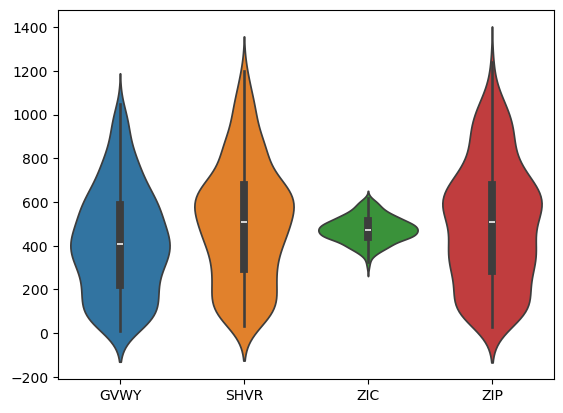

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=1.0794475970877521e-06). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'SHVR', 2.0307526129708024e-06), ('GVWY', 'ZIC', 9.14319478056297e-06), ('GVWY', 'ZIP', 2.5790540430906724e-05)]
-----------------------------------------------------------------------------------------------------
[('SHVR', 2), ('GVWY', 14), ('ZIC', 2), ('ZIP', 2)]
n: 500
50
100
150
200
250
300
350
400
450
GVWY: mean=462.438 std=56.449617133768925
SHVR: mean=471.716 std=277.00700551829436
ZIC: mean=528.848 std=277.49768797173675
ZIP: mean=249.542 std=135.19817057435841
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition: GVWY. Do not reject null hypothesis (p=0.16298727691173553). There is enough evidence to suggest the data is normally distributed
Condition: SHVR. Reject null hypothesis (p=1.4982358607085189e-06). There is enough evidence to suggest 

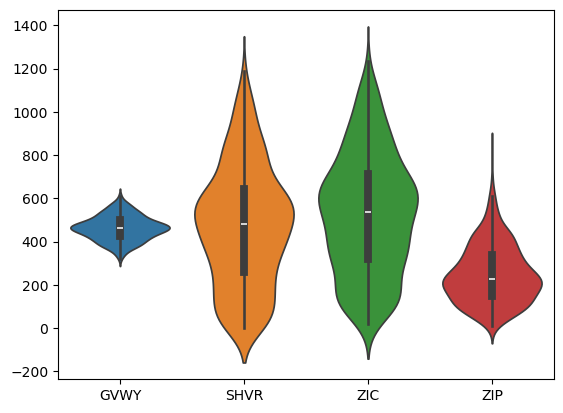

There are 4 distributions. Therefore using Friedman test
Reject null hypothesis (p=2.1442208640054907e-74). There is sufficient evidence to suggest groups have a population different mean
[('GVWY', 'ZIC', 7.881357080978368e-05), ('GVWY', 'ZIP', 1.0727896864186618e-69), ('SHVR', 'ZIC', 0.013332835120287217), ('SHVR', 'ZIP', 3.584518161040663e-36), ('ZIC', 'ZIP', 1.5075586352953497e-49)]
-----------------------------------------------------------------------------------------------------
time: 1701288482.177132


In [17]:
part_c(500)

In [8]:
sup_range = (150, 120)
dem_range = (50, 75)
num_buyers = 10
num_sellers = 10
buyers = [('ZIP', 9), ('ZIPSH', 1)]
sellers = [('ZIP', 10)]
traders_specs = {'sellers': sellers, 'buyers': buyers}
end_time = 60 * 60*24*30
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}

In [ ]:
cwhelpers.run_experiment(50, (start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT.

In [18]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

C:\Users\ge20118\AppData\Local\Temp\ipykernel_26748\1902107979.py:3: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


In [19]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "cw.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 163. Limit is 2000 words.
